# Agent Based Model for Revenge in War Simulation
>Final Project

Project Group: Group 103<br>
Project Member Name: Juanita Ramirez

### Abstract

This project creates an Agent-Based Model with a Social Network environment. Each of the agents has attributes and links that will affect their decision to attack or not the opposite group (revenge) and how harmful the attack will be (strength). In the first step, some agents are initiated randomly.

### Libraries

In [5]:
using Graphs
using GraphPlot
using Agents
using Plots
using Distributions
using Random 
using CairoMakie 

### Graph

The function `two_communities` creates a graph between two communities. For each of the communities, an Albert Barabasi graph is generated with k the number of links that new nodes are attached with preferential attachment to the graph, d the number of links between the two groups, and n, m  representing the number of nodes for each of the respective communities.

In [2]:
# create a conected albert barabasi graph between two groups
function two_communities(n,m,k,d) #n and m number of nodes, new node is attached with k links and preferential attachment, d represent number of links between the communities
    N1=barabasi_albert(n, k)
    N2=barabasi_albert(m,k) ##new edges
    for i in n+1:n+m
        add_vertex!(N1)
    end
    edges_of_N2 = edges(N2) ##adding links
    for edge in edges_of_N2
        s=src(edge)+n #source
        t=dst(edge)+n #target
        add_edge!(N1,s,t)
    end

    for j in 1:d
        add_edge!(N1,rand(1:n),rand((n+1):(n+m)))
    end
    return(N1)
end


two_communities (generic function with 1 method)

the graph is connected? true


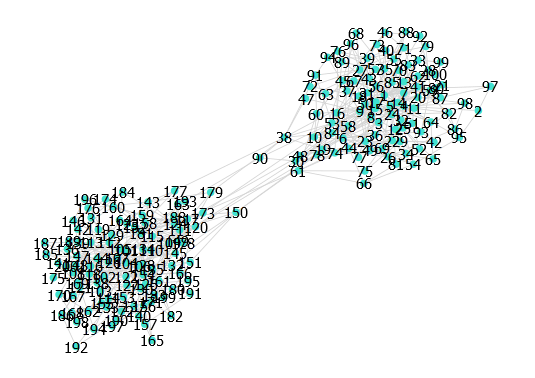

In [3]:
#Example
g=two_communities(100,100,3,10)
node_labels=collect(1:200)
println("the graph is connected? ",is_connected(g))
gplot(g,nodelabel=node_labels,layout=spring_layout)


### Agents and Model

- The environment is a ContinuousSpace, the property social enviroment is the graph generated by two_communities.
- The agents are ContinuousAgent of type Person with id, pos, velocity, health, nationality, residency, violence, strength, and revenge attributes. <br>
The agents positions don not change and correspond to the spring layout positions of the nodes.
- The properties p_revenge and q_violence are used in the agent_step! function

In [4]:
@agent Person ContinuousAgent{2} begin
    health::Float64
    nationality::String
    residency::String
    violence::Float64
    strength::Float64
    revenge::Bool
end

In [6]:
function revenge(;
    numPersonA = 800, #number of people in territory A
    numPersonB= 800, #Number of people in territory B
    k=3, # parameter for two_communities function
    d=40, # parameter for two_communities function
    dim=2.2, # Enviroment dimension
    p=0.2, # if rand()< p and the residency is A, agent is initiated with revenge=true
    pr=0.2,
    qv=0.2
)

    model = ABM(Person, ContinuousSpace((dim, dim);  spacing=0.2);  properties=Dict(:social_network => two_communities(numPersonA,numPersonB,k,d),:p_revenge => pr, :q_violence => qv))
    total=numPersonA+numPersonB

    # vector of x and y positions
    x=spring_layout(model.social_network)[1]
    y=spring_layout(model.social_network)[2]

    #Nationality: Most agents will have nationality = residency, but if rand() > q, the nationality and residency are different. 
    #n= agent id, nA= numPersonA, r= rand(), and q a probabilty value.
    nat(n,nA,r,q)= (n <= nA)  & (r < q) ? "A" : ( (n <= nA) & (r > q) ? "B" : ((n > nA)  & (r > q) ? "A" : "B"))

    #Residency
    res(n,nA)= n <= nA ? "A" : "B"

    for i in 1:length(x)
        x1=x[i,1]+1.1
        y1=y[i,1]+1.1
        pos=(x1,y1)
        ##revenge
        is_attacker= i <= numPersonA
        revenge_flag=is_attacker & (rand() < p)
        ##Add agent
        add_agent!(pos,model,(0,0),3,nat(i,numPersonA,rand(),0.95), res(i,numPersonA),rand(),rand(),revenge_flag)
    end
    return model
end

revenge (generic function with 1 method)

In [7]:
model=revenge()

StandardABM with 1600 agents of type Person
 space: periodic continuous space with (2.2, 2.2) extent and spacing=0.2
 scheduler: fastest
 properties: social_network, p_revenge, q_violence

In [8]:
x=0
for i in values(model.agents)
    x += i.revenge
end
println("$x people in territory A were initiated, with revenge = true")

172 people in territory A were initiated, with revenge = true


- The `attack!` function will lower the victim's health based on the attacker's strength.
- The `nation_condition` function returns a boolean. It is true if the person's nationality is equal to the person's residency and the nationalities of the neighbors. (The person doesn't have foreign friends and is not a foreigner.)
- The `neighbor_victim` function returns a boolean, and it is true when a neighbor has been attacked.

In [9]:
## Attack function
function attack!(attacker::Person,victim::Person)
    victim.health-=attacker.strength
end

## Nation condition
function nation_condition(person,model) 
    l=[]
    for i  in neighbors(model.social_network,person.id)
    append!(l,model[i].nationality == person.nationality) # doesn't have neighbors of different nationality
    end
    return((person.nationality == person.residency) & all(l)) 
end

# verifies if neighbors have been attacked
function neighbor_victim(person,model)
    l=[]
    for i in neighbors(model.social_network,person.id)
        append!(l,model[i].health < 3)
    end
    return(all(l))
end



neighbor_victim (generic function with 1 method)

### Rules

- If a person's revenge is true it will attack a random person in the opposite territory
- A person's revenge will change to true if there is a neighbor's victim and rand() < p_revenge
- A person's revenge will change to false if person.violence < q_violence (the person is not violent)
- A killed person, a foreigner, or a foreign's friend won't attack
- The position does not change for agents.

In [12]:
function agent_step!(person,model)
    if person.health > 0 
        if nation_condition(person,model) == true 
            if person.revenge == true
                if person.residency == "A"
                    victim= random_agent(model, agent -> agent.residency == "B")
                    attack!(person,victim)
                    if person.violence < model.q_violence
                        person.revenge= false
                    end
                else 
                    victim= random_agent(model, agent -> agent.residency == "A")
                    attack!(person,victim)
                    if person.violence < model.q_violence
                        person.revenge= false
                    end
                end
            else 
                revenge_flag= rand() < model.p_revenge
                fv=neighbor_victim(person,model)
                person.revenge= revenge_flag & fv
            end
        else 
            nothing
        end
    else 
        nothing
    end
    move_agent!(person, person.pos, model) #position remains the same
end

agent_step! (generic function with 1 method)

### Visualizations
- Blue: agents with nationality A
- Orange: agents with nationality B
- Red: wounded agents
- Black: agents killed

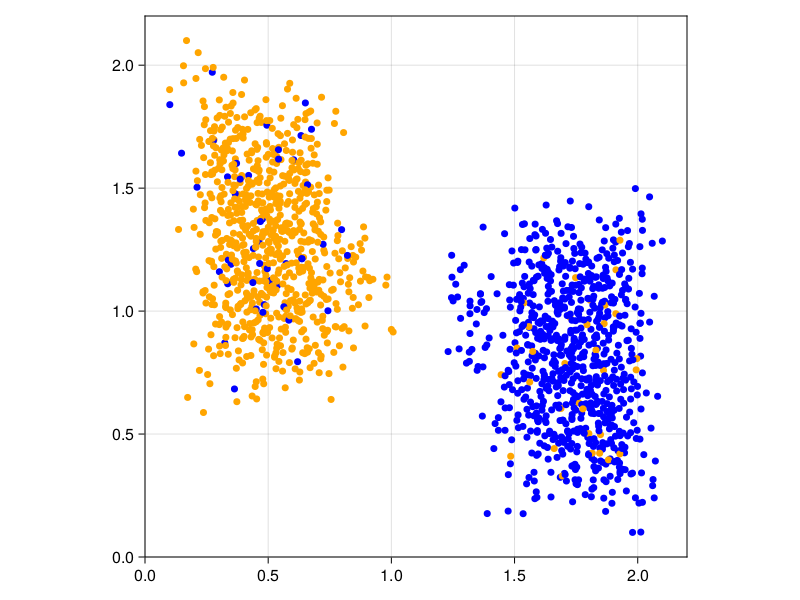

In [10]:
groupcolor(a) = a.health <= 0 ? :black : (a.health < 3 ? :red : (a.nationality == "A" ? :blue : :orange))
figure, _ = abmplot(model; ac = groupcolor, as = 10,label = :id)
figure # returning the figure displays it

In [13]:
abmvideo("revenge.mp4", model, agent_step!;
    title = "Revenge", framerate = 15, frames = 50,
    ac = groupcolor
)

### Statistics

In [14]:
function fig(model)
    dead_in_A(a) =(a.residency == "A") & (a.health <= 0)
    dead_in_B(a) =(a.residency == "B") & (a.health <= 0)
    safe_in_A(a) =(a.residency == "A") & (a.health == 3)
    safe_in_B(a) =(a.residency == "B") & (a.health == 3)
    wounded_in_A(a) =(a.residency == "A") & (0 < a.health < 3)
    wounded_in_B(a) =(a.residency == "B") & (0 < a.health < 3)
    adata = [(dead_in_A, count),(safe_in_A, count),(wounded_in_A,count),(dead_in_B, count),(safe_in_B, count),(wounded_in_B,count)]
    #model=revenge()
    agent_df, model_df = run!(model, agent_step!, 50; adata)


    figure = CairoMakie.Figure(resolution = (600, 600))
    ax1 = figure[1, 1] = Axis(figure, ylabel = "People count in A")
    dead_in_Al = lines!(ax1, agent_df[!, :step], agent_df[!, :count_dead_in_A], color = :black)
    safe_in_Al = lines!(ax1, agent_df[!, :step], agent_df[!, :count_safe_in_A], color = :blue)
    wounded_in_Al = lines!(ax1, agent_df[!, :step], agent_df[!, :count_wounded_in_A], color = :red)
    figure[1, 2] = Legend(figure, [dead_in_Al,safe_in_Al,wounded_in_Al], ["dead", "safe","wounded"])

    ax2 = figure[2, 1] = Axis(figure, ylabel = "People count in B")
    dead_in_Bl = lines!(ax2, agent_df[!, :step], agent_df[!, :count_dead_in_B], color = :black)
    safe_in_Bl = lines!(ax2, agent_df[!, :step], agent_df[!, :count_safe_in_B], color = :orange)
    wounded_in_Bl = lines!(ax2, agent_df[!, :step], agent_df[!, :count_wounded_in_B], color = :red)
    figure[2, 2] = Legend(figure, [dead_in_Bl,safe_in_Bl,wounded_in_Bl], ["dead", "safe","wounded"])

    return(figure)
end

fig (generic function with 1 method)

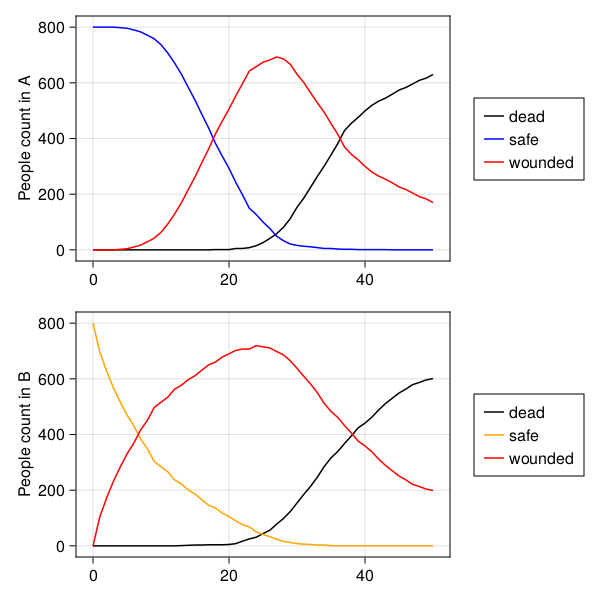

In [15]:
model1=revenge()
fig(model1)

In [16]:
model2=revenge(
d=200, # parameter for two_communities function
qv=0.5)

StandardABM with 1600 agents of type Person
 space: periodic continuous space with (2.2, 2.2) extent and spacing=0.2
 scheduler: fastest
 properties: social_network, p_revenge, q_violence

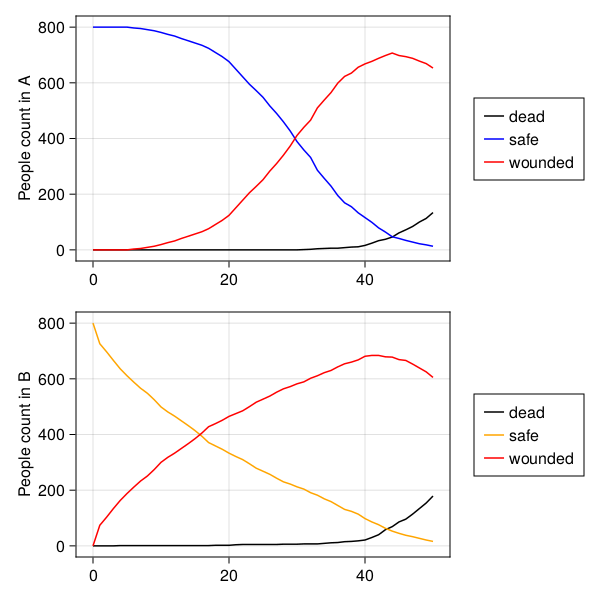

In [17]:
fig(model2)

In [18]:
model3=revenge(
d=200, # parameter for two_communities function
pr=0.5)

StandardABM with 1600 agents of type Person
 space: periodic continuous space with (2.2, 2.2) extent and spacing=0.2
 scheduler: fastest
 properties: social_network, p_revenge, q_violence

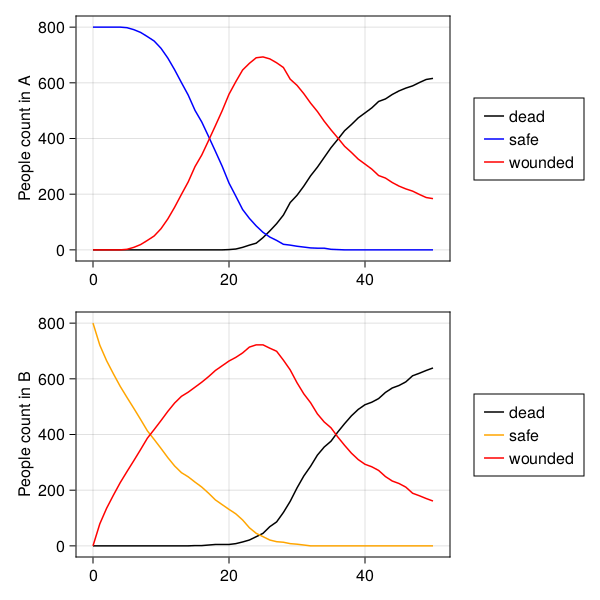

In [19]:
fig(model3)

In [20]:
model4=revenge(
d=200, # parameter for two_communities function
pr=0.5,
qv=0.5)

StandardABM with 1600 agents of type Person
 space: periodic continuous space with (2.2, 2.2) extent and spacing=0.2
 scheduler: fastest
 properties: social_network, p_revenge, q_violence

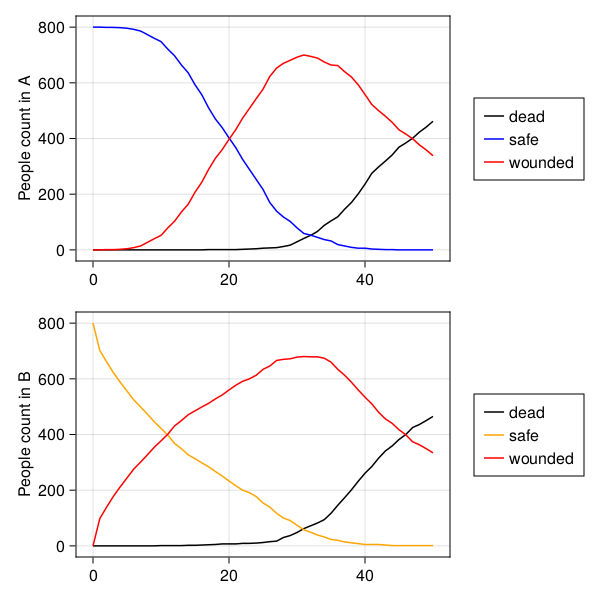

In [21]:
fig(model4)

### Conclusions:

- The properties p_revenge and q_violence affect the results of the model:

    - q_violence is related to people who change revenge to false, if q_violence is larger as observed in model 2 fewer people are dead compared to other models, and d was larger representing more people who are friends of foreign people.

    - Model 1 has a high level of violence, low level of revenge, and low d. Resulting in more deaths.
    
    - Model 3 and model 4 have similar results compared to model 1, showing the high impact of revenge, even when there are more links between groups and more people are considered not violent.